In [1]:
# Nearest Neighbor Analysis with AutoEncoder Latent Representation

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torchvision
import numpy as np
from scipy.spatial.distance import cdist

In [4]:
# Training Images

import os
root = 'data_faces/img_align_celeba'
timg_list = os.listdir(root)
print(len(timg_list))

202599


In [5]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image as Image
import torch
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
""" data """
crop_size = 108
re_size = 32
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Scale(size=(re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 64


# Transformed Training Images
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [6]:
# Generated Images

import os
root = 'sep_images_folder/sep_imgs'
gimg_list = os.listdir(root)
print(len(gimg_list))

6400


In [7]:
generated_transform = transforms.Compose([transforms.ToTensor()])
generated_celeb_data = datasets.ImageFolder('./sep_images_folder', transform = generated_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


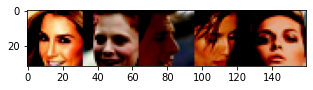

In [8]:
# Training Images

# Let's display some of the training samples.
sample_images = []
celeba_data_iter = iter(celeba_data) 
for _ in range(5):
  sample = next(celeba_data_iter)    
  sample_images.append(np.transpose(sample[0].data.cpu().numpy(), (1,2,0)))

fig = plt.figure(figsize = (5, 25))   
ax1 = plt.subplot(111)
ax1.imshow(np.concatenate(sample_images, axis=1), cmap='gray')
plt.show()

In [9]:
batch_size = 64
nworkers = 4 

# Training Dataloader
training_data_loader = DataLoader(celeba_data, batch_size=batch_size, shuffle=True, num_workers=nworkers)

In [10]:
# Encoder and Decoder Network

import torch.nn as nn

class Encoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.net = nn.Sequential(
        
        nn.Conv2d(3, 32, kernel_size = 4, stride = 2, padding = 1), # (B, 32 ,16, 16)
        nn.LeakyReLU(0.1),

        nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1), # (B, 64, 8, 8)
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1),

        nn.Conv2d(64 ,128, kernel_size = 4, stride = 2, padding = 0), # (B, 128, 3, 3)
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1),

        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 0), #(B, 256, 1, 1)
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.1),

        nn.Flatten(),
        nn.Linear(256, nz) 
    )
  
  def forward(self, x):
    return self.net(x)

class Decoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.map = nn.Linear(nz, 256)   # for initial Linear layer
    self.net = nn.Sequential(

        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 1, padding = 0), 

        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 0),  

        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1),  

        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.1),
        nn.ConvTranspose2d(32, 3, kernel_size = 4, stride = 2, padding = 1),  

        nn.Sigmoid()
    )
  
  def forward(self, x):
    return self.net(self.map(x).reshape(-1, 256, 1, 1))


In [11]:
nz = 64  # dimensionality of the learned embedding
encoder = Encoder(nz)
decoder = Decoder(nz)
for sample_img, sample_label in training_data_loader:
  enc = encoder(sample_img)
  print("Shape of encoding vector (should be [batch_size, nz]): {}".format(enc.shape))
  dec = decoder(enc)
  print("Shape of decoded image (should be [batch_size, 3, 32, 32]): {}".format(dec.shape))    
  break

Shape of encoding vector (should be [batch_size, nz]): torch.Size([64, 64])
Shape of decoded image (should be [batch_size, 3, 32, 32]): torch.Size([64, 3, 32, 32])


In [12]:
class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.encoder = Encoder(nz)
    self.decoder = Decoder(nz)

  def forward(self, x):
    return self.decoder(self.encoder(x))

  def reconstruct(self, x):
    """Only used later for visualization."""
    return self.forward(x)

  def encode(self, x):
    return self.encoder(x)

In [13]:
def save_model(model):
  torch.save(model.state_dict(), './MMD_autoencoder.pkl')
  print('Model saved to ./MMD_autoencoder.pkl ..')

In [14]:
epochs = 9
learning_rate = 5e-4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   
ae_model = AutoEncoder(nz).to(device)    
ae_model = ae_model.train()  

opt = torch.optim.Adam(ae_model.parameters(), lr=learning_rate) # optimizer instance
criterion = nn.MSELoss()       

In [15]:
ae_model.load_state_dict(torch.load('./MMD_autoencoder.pkl'))

<All keys matched successfully>

In [16]:
train_it = 0
batch_num = 0
for ep in range(epochs):
  print("Run Epoch {}".format(ep))
  for image_batch, _ in training_data_loader:
    image_batch = image_batch.cuda()
    recon_img = ae_model(image_batch)
    rec_loss = criterion(recon_img, image_batch) 
    rec_loss.backward() 
    opt.step()
    opt.zero_grad() 

    if train_it % 100 == 0:
      print("It {}: Reconstruction Loss: {}".format(train_it, rec_loss))
    train_it += 1
    
  if ep % 3 == 0:
    save_model(ae_model)

Run Epoch 0
It 0: Reconstruction Loss: 0.2081153243780136
It 100: Reconstruction Loss: 0.1922207772731781
It 200: Reconstruction Loss: 0.17032253742218018
It 300: Reconstruction Loss: 0.18932120501995087
It 400: Reconstruction Loss: 0.1912693828344345
It 500: Reconstruction Loss: 0.19813142716884613
It 600: Reconstruction Loss: 0.18073563277721405
It 700: Reconstruction Loss: 0.18813352286815643
It 800: Reconstruction Loss: 0.1971694529056549
It 900: Reconstruction Loss: 0.1788114756345749
It 1000: Reconstruction Loss: 0.1743423193693161
It 1100: Reconstruction Loss: 0.18171554803848267
It 1200: Reconstruction Loss: 0.17494432628154755
It 1300: Reconstruction Loss: 0.18137888610363007
It 1400: Reconstruction Loss: 0.16917215287685394
It 1500: Reconstruction Loss: 0.16848604381084442
It 1600: Reconstruction Loss: 0.19313326478004456
It 1700: Reconstruction Loss: 0.21311935782432556
It 1800: Reconstruction Loss: 0.2028830349445343
It 1900: Reconstruction Loss: 0.2148369997739792
It 2000:

It 16100: Reconstruction Loss: 0.20615792274475098
It 16200: Reconstruction Loss: 0.19201473891735077
It 16300: Reconstruction Loss: 0.17779633402824402
It 16400: Reconstruction Loss: 0.17887535691261292
It 16500: Reconstruction Loss: 0.16978149116039276
It 16600: Reconstruction Loss: 0.19739793241024017
It 16700: Reconstruction Loss: 0.18173865973949432
It 16800: Reconstruction Loss: 0.19738689064979553
It 16900: Reconstruction Loss: 0.17913423478603363
It 17000: Reconstruction Loss: 0.16705505549907684
It 17100: Reconstruction Loss: 0.19177505373954773
It 17200: Reconstruction Loss: 0.2022532820701599
It 17300: Reconstruction Loss: 0.19511494040489197
It 17400: Reconstruction Loss: 0.17376083135604858
It 17500: Reconstruction Loss: 0.2164941430091858
It 17600: Reconstruction Loss: 0.197723388671875
It 17700: Reconstruction Loss: 0.17155486345291138
It 17800: Reconstruction Loss: 0.2002408504486084
It 17900: Reconstruction Loss: 0.21974317729473114
It 18000: Reconstruction Loss: 0.200

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


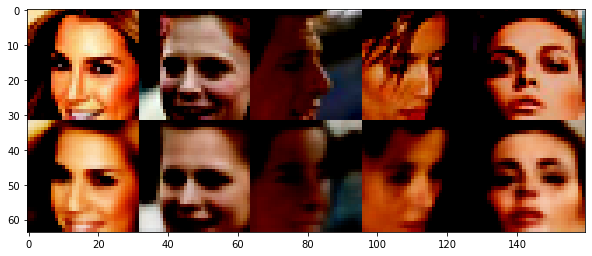

In [16]:
# visualize test data reconstructions
def vis_reconstruction(model):
  
  celeba_data_iter = iter(celeba_data) 
  model.eval()      
  input_imgs, test_reconstructions = [], []
  for _ in range(5):
    input_img = np.asarray(next(celeba_data_iter)[0])
    reconstruction = model.reconstruct(torch.tensor(input_img[None], device=device))
    input_imgs.append(np.transpose(input_img,(1,2,0)))
    test_reconstructions.append(np.transpose(reconstruction[0].data.cpu().numpy(),(1,2,0)))

  fig = plt.figure(figsize = (10, 25))   
  ax1 = plt.subplot(111)
  ax1.imshow(np.concatenate([np.concatenate(input_imgs, axis=1),
                            np.concatenate(test_reconstructions, axis=1)], axis=0))
  plt.show()

vis_reconstruction(ae_model)

In [17]:
# Generated Images DataLoader
generated_data_loader = DataLoader(generated_celeb_data, batch_size=batch_size, shuffle=True, num_workers=nworkers)

In [18]:
# Latent Representation of Both Training Image an Generated Images.

# Generated Images
z_gen_list = []
for batch, _ in generated_data_loader:
    batch = batch.to(device)
    z_generated = ae_model.encode(batch)
    z_gen_list.append(z_generated.cpu().data.numpy())

z_generated = np.concatenate(z_gen_list)

In [19]:
print(z_generated.shape)

(6400, 64)


In [20]:
# Training Images
z_train_list = []
batch_num = 0
for batch, _ in training_data_loader:
    batch_num += 1
    if batch_num == 101:
        break
    batch = batch.to(device)
    z_train = ae_model.encode(batch)
    z_train_list.append(z_train.cpu().data.numpy())

z_train = np.concatenate(z_train_list)

In [21]:
print(z_train.shape)

(6400, 64)


In [22]:
dist = cdist(z_train, z_generated, 'chebyshev')

In [23]:
# Actual Training and Generated Image (not z)
# Training
celeba_data_list = []
batch_num = 0
for batch,_ in training_data_loader:
    batch_num += 1
    if batch_num == 101:
        break
    celeba_data_list.append(batch.numpy())
    

celeba_data = np.concatenate(celeba_data_list)

# Generated
generated_celeb_data = np.concatenate([batch.numpy() for batch, _ in generated_data_loader])

In [24]:
min_dis = np.argmin(dist, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


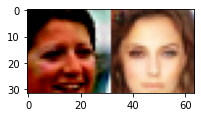

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


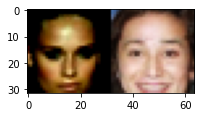

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


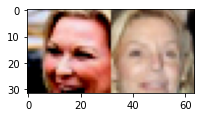

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


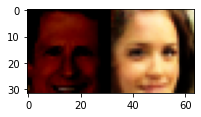

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


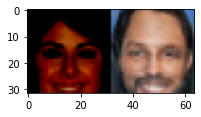

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


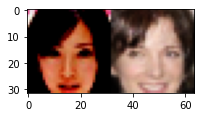

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


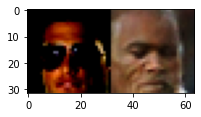

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


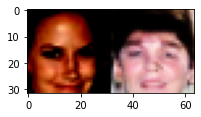

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


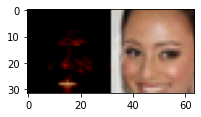

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


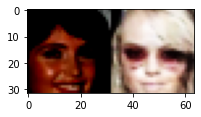

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


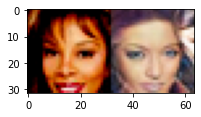

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


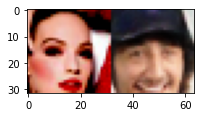

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


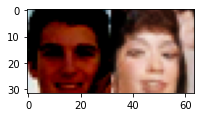

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


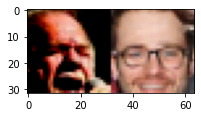

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


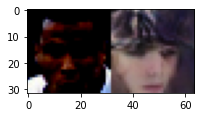

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


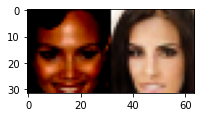

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


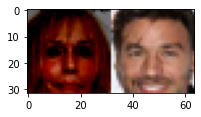

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


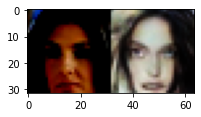

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


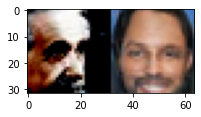

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


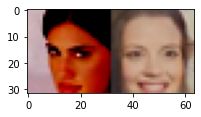

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


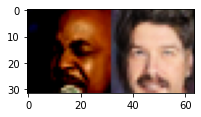

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


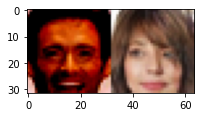

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


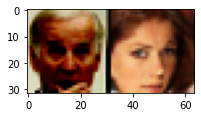

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


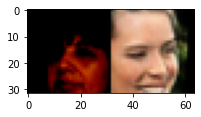

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


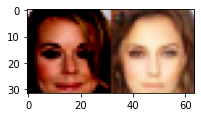

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


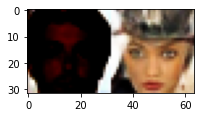

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


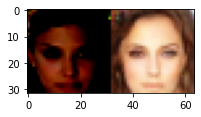

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


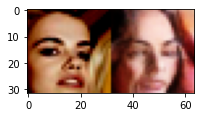

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


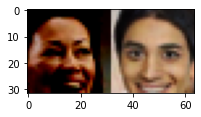

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


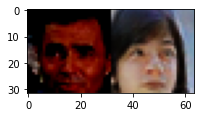

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


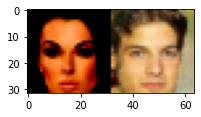

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


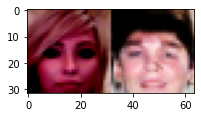

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


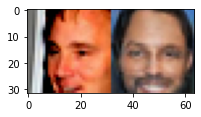

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


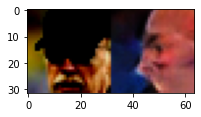

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


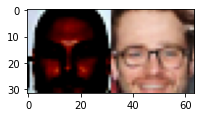

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


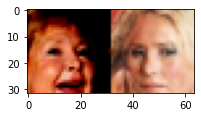

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


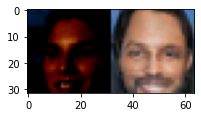

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


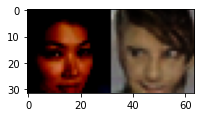

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


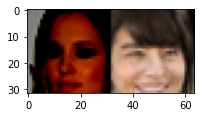

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


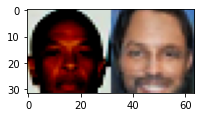

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


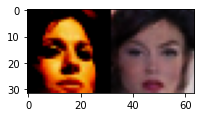

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


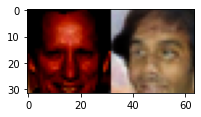

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


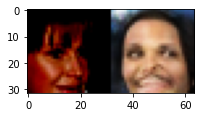

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


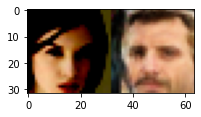

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


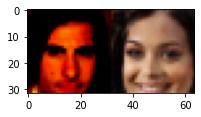

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


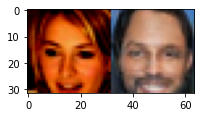

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


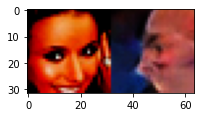

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


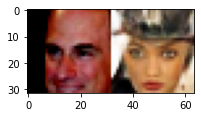

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


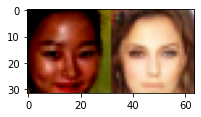

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


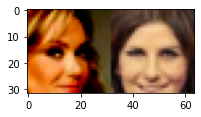

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


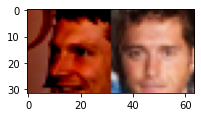

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


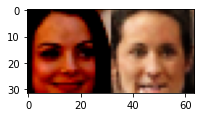

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


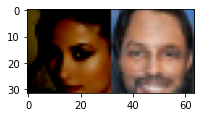

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


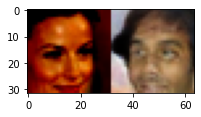

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


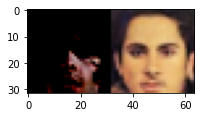

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


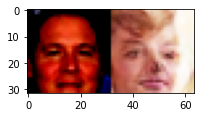

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


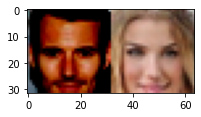

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


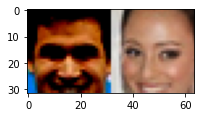

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


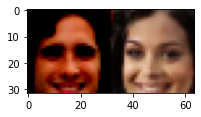

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


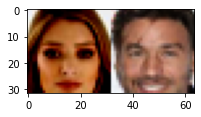

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


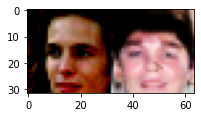

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


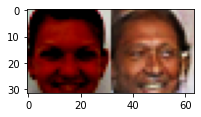

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


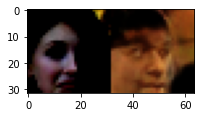

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


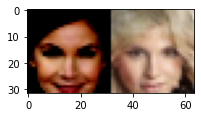

In [25]:
# Nearest Neighbor Analysis with latent variable of dim64 using AutoEncoder
for train_i in range(64, 128, 1):
  train_gen = []
  train_img = celeba_data[train_i] 
  train_gen.append(np.transpose(train_img, (1,2,0)))
  gen_img = generated_celeb_data[min_dis[train_i]]
  train_gen.append(np.transpose(gen_img, (1,2,0)))

  fig = plt.figure(figsize = (3, 3))   
  ax1 = plt.subplot(111)
  ax1.imshow(np.concatenate(train_gen, axis=1))
  plt.show()

In [ ]:
# Maximum Mean Discrepancy / Drift
